In [1]:
make_new_data = True
train_new_model = True
log_wandb = True

import numpy as np
np.random.seed(42)

import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pickle
import wandb
from sklearn.model_selection import train_test_split

from make_analogies_functions import *

num_samples = 100000 #each sample is a trio of images of which each comes in various forms (analogous transformations).
img_size = 10
pairs_per_task = 3
shape = "rectangle" #rectangle or L
all_images = []
method_names = ["Grown", "Moved", "Rotated", "Inverted", "Mirrored", "Close/Far Corners", "Close/Far Edges", "Stretched", "Shadows", "Gravity", "Count"]
seed_iteration = 0
data = []
num_epochs = 80
batch_size = 512
learning_rate = 0.001
use_lr_scheduler = False

In [2]:
if make_new_data:
    for i in range(num_samples):    
        trios = []
        invalid_img = True
        while invalid_img:
            seed_iteration += 1
            np.random.seed(seed_iteration)

            #make 3 random images with rectangles
            trio = [create_image(img_size = img_size, shape = shape) for _ in range(pairs_per_task)]

            #sample parameters for analogies
            mirror_horizontal = np.random.choice([True, False])
            rotation_degree = np.random.choice([90, 180, 270])
            grow_left = np.random.choice([0,0,1,2])
            grow_right = np.random.choice([0,0,1,2])
            grow_top = np.random.choice([0,0,1,2])
            grow_bottom = np.random.choice([0,0,1,2])
            move_vertical = np.random.choice([-2,-1,0,1,2])
            move_horizontal = np.random.choice([-2,-1,0,1,2])
            furthest_edge = np.random.choice([True, False])
            furthest_corner = np.random.choice([True, False])
            reverse_shadows = np.random.choice([True, False])
            gravity_direction = np.random.choice(["up","down","left","right"])
            count_left_right = np.random.choice([True, False])
            count_top_bottom = np.random.choice([True, False])

            # Generate analogies
            growths = [grow(img, grow_top, grow_bottom, grow_left, grow_right) for img in trio]
            moves = [move(img, move_horizontal, move_vertical)  for img in trio]
            rotations = [rotate_image(img, rotation_degree) for img in trio]
            inversions = [invert_colors(img)  for img in trio]
            mirrors = [mirror_image(img, horizontal=mirror_horizontal) for img in trio]
            corner_cells = [paint_corner(img, furthest_corner) for img in trio]
            edges = [paint_edge(img, furthest_edge) for img in trio]
            stretches = [stretch_rectangle(img) for img in trio]
            shadows = [draw_shadows(img, reverse_shadows)  for img in trio]
            gravities = [gravity(img, gravity_direction)  for img in trio]
            counts = [count_pixels(img, count_left_right, count_top_bottom) for img in trio]
            
            #check whether images violate rules (original three include duplicates; initial transformations left the canvas)
            if np.array_equal(trio[0], trio[1]) or np.array_equal(trio[0], trio[2]) or np.array_equal(trio[1], trio[2]):
                invalid_img = True
            elif invalid_matrix(moves[0], img_size, img_size, 1):
                invalid_img = True
            elif invalid_matrix(growths[0], img_size, img_size, 1):
                invalid_img = True
            else:
                invalid_img = False
        
        transformed_trios = [growths, moves, rotations, inversions, mirrors, corner_cells, edges, stretches, shadows, gravities, counts]
        data.append([np.stack([trio, transformed_trio]) for transformed_trio in transformed_trios])

    data = np.array(data)

    long_data = data.reshape(data.shape[0]*data.shape[1], data.shape[2], data.shape[3], data.shape[4], data.shape[5])
    long_data = long_data.reshape(long_data.shape[0], long_data.shape[1] * long_data.shape[2], long_data.shape[3], long_data.shape[4])
    method_index = np.tile(method_names, num_samples)
    nonduplicates, unique_ind = np.unique(long_data, axis=0, return_index=True) #get rid of duplicated tasks; could be stricter by also considering flipped fewshot orders as duplicated
    method_index = method_index[unique_ind]
    print(f"{np.round(100*(1 - nonduplicates.shape[0] / long_data.shape[0]), 1)}% double trios were duplicated") 
    print(long_data.shape)

0.1% double trios were duplicated
(1100000, 6, 10, 10)


Count


<Figure size 1200x400 with 0 Axes>

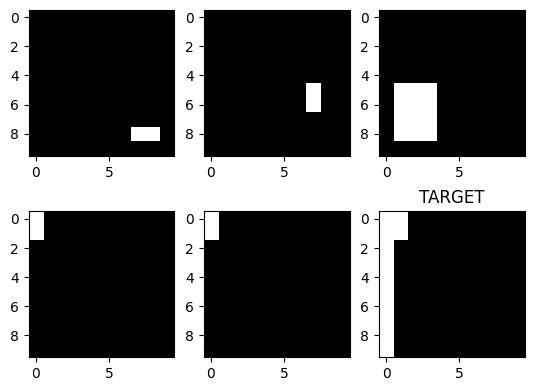

In [3]:
print(method_index[10978])
plot_double_trio(nonduplicates[10978])

In [4]:
if make_new_data:
    with open(f"nonduplicates_{shape}.pkl", "wb") as f:
        pickle.dump(nonduplicates, file=f)
    with open(f"method_index_{shape}.pkl", "wb") as f:
        pickle.dump(method_index, file=f)
else:
    with open(f"nonduplicates_{shape}.pkl", "rb") as f:
        nonduplicates = pickle.load(file=f)
    with open(f"method_index_{shape}.pkl", "rb") as f:
        method_index = pickle.load(file=f)

In [5]:
# Split into input (x) and output (y)
x_data = nonduplicates[:, :-1, :, :] / 255 # All but the last channel
y_data = nonduplicates[:, -1, :, :] / 255  # Only the last channel
x_data = torch.from_numpy(x_data).float()
y_data = torch.from_numpy(y_data).float()
x_train, x_test, y_train, y_test, methods_train, methods_test = train_test_split(x_data, y_data, method_index, test_size=0.005, random_state=42)
print(f"x_train: {x_train.shape},\ny_train: {y_train.shape},\nx_test: {x_test.shape},\ny_test: {y_test.shape}")
print(f"train methods: {methods_train[0:3]}")
print(f"test methods: {methods_test[0:3]}")
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

x_train: torch.Size([1093500, 5, 10, 10]),
y_train: torch.Size([1093500, 10, 10]),
x_test: torch.Size([5495, 5, 10, 10]),
y_test: torch.Size([5495, 10, 10])
train methods: ['Shadows' 'Count' 'Inverted']
test methods: ['Gravity' 'Close/Far Edges' 'Grown']


In [6]:
%%capture
if train_new_model and log_wandb:
    wandb.init(
        project="simpleARC",
        config={
        "architecture": FullyConnectedNN,
        "shape": shape,
        "img_size": img_size,
        "pairs_per_task": pairs_per_task,
        "analogies": method_names,
        "epochs": num_epochs,
        "learning_rate": learning_rate,
        "use_lr_scheduler": use_lr_scheduler})

In [7]:
torch.manual_seed(42)
if train_new_model:
    model = FullyConnectedNN().to(device)
    print(f"Nr params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
    if use_lr_scheduler:
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=num_epochs, verbose=True)

    for epoch in range(num_epochs):
        for (inputs, labels) in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            model.train()
            optimizer.zero_grad()
            train_outputs = model(inputs)
            loss = criterion(train_outputs, labels)
            loss.backward()
            optimizer.step()
        if use_lr_scheduler:
            scheduler.step()

        test_metrics = get_test_metrics(x_test, y_test, model, criterion, methods_test, True)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Test: {test_metrics["test loss"]:.4f}, %solved: {test_metrics["percent_solved"]:.2f}')
        if log_wandb:
            wandb.log({"epoch": epoch + 1, "train Loss": loss.item()} | test_metrics)

    torch.save(model.state_dict(), f'model_trained_on_{shape}.pth')
else:
    model = FullyConnectedNN()
    model.load_state_dict(torch.load(f'model_trained_on_{shape}.pth'))

Nr params: 200700
Epoch [1/80], Loss: 0.0808, Test: 0.0782, %solved: 26.22
Epoch [2/80], Loss: 0.0505, Test: 0.0489, %solved: 45.88
Epoch [3/80], Loss: 0.0358, Test: 0.0355, %solved: 56.25
Epoch [4/80], Loss: 0.0243, Test: 0.0280, %solved: 63.75
Epoch [5/80], Loss: 0.0286, Test: 0.0228, %solved: 69.46
Epoch [6/80], Loss: 0.0182, Test: 0.0198, %solved: 71.45
Epoch [7/80], Loss: 0.0180, Test: 0.0166, %solved: 75.20
Epoch [8/80], Loss: 0.0123, Test: 0.0148, %solved: 77.16
Epoch [9/80], Loss: 0.0127, Test: 0.0142, %solved: 78.71
Epoch [10/80], Loss: 0.0133, Test: 0.0123, %solved: 80.93
Epoch [11/80], Loss: 0.0112, Test: 0.0117, %solved: 82.44
Epoch [12/80], Loss: 0.0077, Test: 0.0110, %solved: 82.53
Epoch [13/80], Loss: 0.0086, Test: 0.0099, %solved: 83.86
Epoch [14/80], Loss: 0.0080, Test: 0.0095, %solved: 85.51
Epoch [15/80], Loss: 0.0049, Test: 0.0083, %solved: 85.82
Epoch [16/80], Loss: 0.0073, Test: 0.0085, %solved: 87.01
Epoch [17/80], Loss: 0.0076, Test: 0.0082, %solved: 87.90
Epoch

Test set example:


<Figure size 1200x400 with 0 Axes>

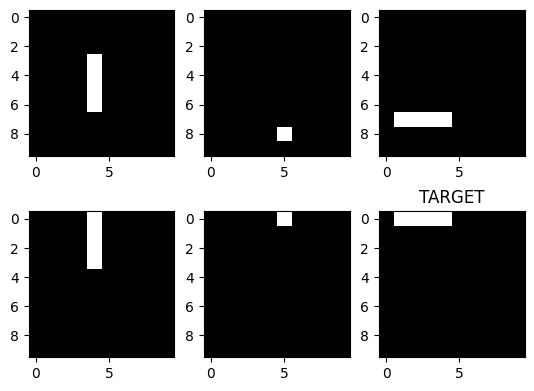

Prediction:


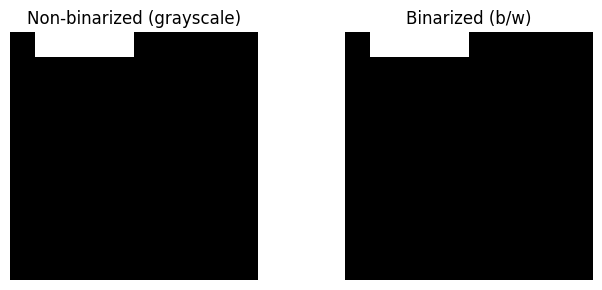

Most similar training case:


<Figure size 1200x400 with 0 Axes>

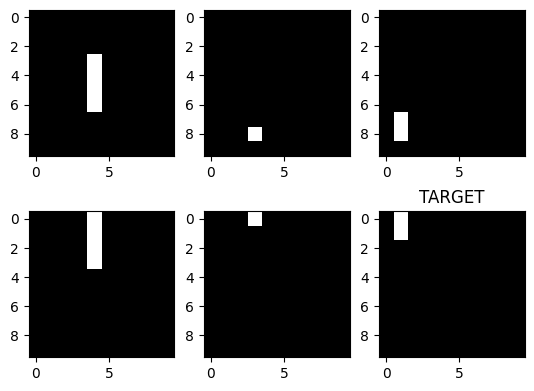

In [8]:
plot_exmp = 0
with torch.no_grad():
    print("Test set example:")
    y  = y_test[plot_exmp].expand(1, y_test[plot_exmp].shape[0], y_test[plot_exmp].shape[1])
    example = torch.row_stack((x_test[plot_exmp], y))
    plot_double_trio(example)

    print("Prediction:")
    tensor = model(x_test[plot_exmp].unsqueeze(0))[0]
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))  # 1 row, 2 columns
    axs[0].set_title("Non-binarized (grayscale)")
    axs[0].imshow(tensor, cmap='gray')
    axs[0].axis('off')
    axs[1].set_title("Binarized (b/w)")
    axs[1].imshow(torch.round(tensor), cmap='gray')
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()
    
    print("Most similar training case:")
    distances = [torch.sum(torch.abs(x_test[plot_exmp] - np.array(x_train[i]))).item() for i in range(x_train.shape[0])]
    sim_index = np.argmin(distances)
    y  = y_train[sim_index].expand(1, y_train[sim_index].shape[0], y_train[sim_index].shape[1])
    plot_double_trio(torch.row_stack((x_train[sim_index], y)))

In [12]:
#predict on other datafile (e.g. differently shaped figures)
test_shape = "L"
with open(f"nonduplicates_{test_shape}.pkl", "rb") as f:
    added_test_data = pickle.load(file=f)
with open(f"method_index_{test_shape}.pkl", "rb") as f:
    methods_from_added_data = pickle.load(file=f)
added_x_data = added_test_data[:, :-1, :, :] / 255 # All but the last channel
added_y_data = added_test_data[:, -1, :, :] / 255  # Only the last channel
added_x_data = torch.from_numpy(added_x_data).float()
added_y_data = torch.from_numpy(added_y_data).float()

Example from additional dataset:


<Figure size 1200x400 with 0 Axes>

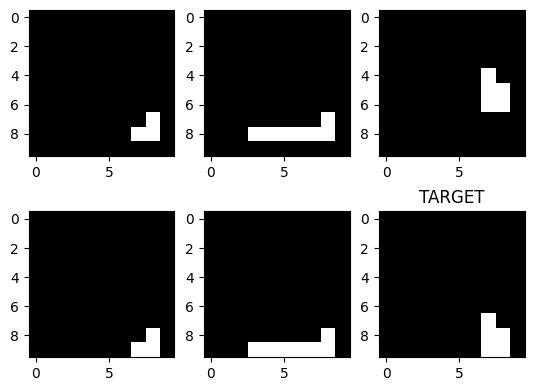

Prediction:


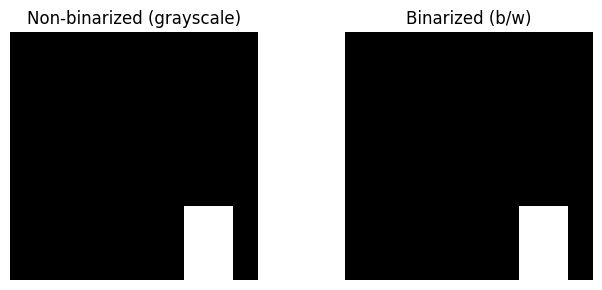

In [13]:
#predict on other datafile (e.g. differently shaped figures)
plot_exmp = 0
with torch.no_grad():
    print("Example from additional dataset:")
    added_y  = added_y_data[plot_exmp].expand(1, added_y_data[plot_exmp].shape[0], added_y_data[plot_exmp].shape[1])
    example = torch.row_stack((added_x_data[plot_exmp], added_y))
    plot_double_trio(example)
    print("Prediction:")
    tensor = model(added_x_data[plot_exmp].unsqueeze(0))[0]
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))  # 1 row, 2 columns
    axs[0].set_title("Non-binarized (grayscale)")
    axs[0].imshow(tensor, cmap='gray')
    axs[0].axis('off')
    axs[1].set_title("Binarized (b/w)")
    axs[1].imshow(torch.round(tensor), cmap='gray')
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()

In [14]:
get_test_metrics(added_x_data, added_y_data, model, criterion, methods_from_added_data, True)

{'test loss': 0.6366866230964661,
 'percent_solved': 22.492602823483168,
 'Close/Far Corners': 2.4360243602436027,
 'Close/Far Edges': 3.988039880398804,
 'Count': 63.47663476634766,
 'Gravity': 3.64,
 'Grown': 2.994,
 'Inverted': 20.90420904209042,
 'Mirrored': 2.6270262702627023,
 'Moved': 5.029523088569265,
 'Rotated': 2.957029570295703,
 'Shadows': 82.116,
 'Stretched': 57.088570885708855}